In [1]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import bayessplicedmodels as bsm
from joblib import Parallel, delayed

# Inverse Gamma distribution

$X\sim\text{Inverse - Gamma}(r, m)$ with pdfs

$$
f(x) = \frac{e^{-m/x}m^r}{x^{r+1}\gamma(r)}
$$

In [2]:
@nb.jit(nopython = True)
def reg_inc_gamma(a,x):
   
    xam = -x + a * np.log(x)
    if x <= 1 + a:
        s = 1/a
        r = s
        for j in np.arange(1, 61, 1):
            r = r * x / (a + j)
            s = s + r
            if (abs(r /s) < 1e-15):
                break
        gin  = np.exp(xam) * s
        ga = ma.gamma(a)
        gip = gin / ga
        gim = ga - gin
    else:
        t0 = 0
        for j in np.flip(np.arange(1, 61, 1)):
            t0 = (j - a) / (1 + j / (x + t0))
        gim  = np.exp(xam) / (x + t0)
        ga = ma.gamma(a)
        gin = ga - gim
        gip = 1 - gim / ga
    return(gip)

In [3]:
class loss_model:
    def __init__(self,name, parm_names):
        self.name = name
        self.parm_names = parm_names
        self.d= len(parm_names)
        
    def set_logp(self, X):
        if self.name == "Inverse-Gamma":
            def logp(parms):
                r, m = parms
                if np.all(parms > 0):
                    return(-m * np.sum(1 / X)  - (r + 1)* np.sum(np.log(X)) - len(X) * np.log(ma.gamma(r)) + r * len(X) * np.log(m))
                else:
                    return(-np.inf)
        self.logp = nb.jit(nopython = True)(logp)
    
    def set_logps(self):
        if self.name == "Inverse-Gamma":

            def logp_body(X, parms,  γ):
                r, m = parms
                F1 = 1-reg_inc_gamma(r, m / γ )
                if np.all(parms > 0) and F1 > 0:
                    return(-m * np.sum(1 / X)  - (r + 1)* np.sum(np.log(X)) - len(X) * np.log(ma.gamma(r)) + r * len(X) * np.log(m) - len(X) * np.log(F1))
                else:
                    return(-np.inf)
            
            def logp_tail(X, parms,  γ):
                r, m = parms
                F2 = 1-reg_inc_gamma(r, m / γ )
                if np.all(parms > 0) and F2 < 1:
                    return(-m * np.sum(1 / X)  - (r + 1)* np.sum(np.log(X)) - len(X) * np.log(ma.gamma(r)) + r * len(X) * np.log(m) - len(X) * np.log(1 - F2))
                else:
                    return(-np.inf)
            
            self.logp_body = nb.jit(nopython = True)(logp_body)
            self.logp_tail = nb.jit(nopython = True)(logp_tail)
    def set_logd(self, parms):
        if self.name == "Inverse-Gamma":
            r , m = parms[:,0], parms[:,1]
            def logd(x):
                
                res = np.zeros(len(r))
                s = np.logical_and(r > 0, m > 0)
                res[np.where(s)] = -m[s] / x  - (r[s] + 1)* np.log(x) - np.log(sp.gamma(r[s])) + r[s] * np.log(m[s])
                res[np.where(np.invert(s))] = -np.inf
                return(res)
        self.logd = logd
        
    def set_logds(self):
        if self.name == "Inverse-Gamma":
            
            def logd_body(x, parms,  γ):
                r , m = parms[:,0], parms[:,1]
                res = np.zeros(len(r))
                s = np.logical_and(np.logical_and(r > 0, m > 0), x < γ)
                res[np.where(s)] = -m[s] / x  - (r[s] + 1)* np.log(x) - np.log(sp.gamma(r[s])) + r[s] * np.log(m[s]) - np.log(1-sp.gammainc(r[s], m[s] / γ[s]))
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            def logd_tail(x, parms,  γ):
                r , m = parms[:,0], parms[:,1]
                res = np.zeros(len(r))
                s = np.logical_and(np.logical_and(r > 0, m > 0), x > γ)
                res[np.where(s)] = -m[s] / x  - (r[s] + 1)* np.log(x) - np.log(sp.gamma(r[s])) + r[s] * np.log(m[s]) - np.log(sp.gammainc(r[s], m[s] / γ[s]))
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            self.logd_body = logd_body
            self.logd_tail = logd_tail
    
    def set_cdf(self):
        if self.name == "Inverse-Gamma":
            def cdf(parms, x):
                r , m = parms
                return(1-reg_inc_gamma(r, m / x))
        self.cdf = nb.jit(nopython = True)(cdf)
    
    def set_pdf(self):
        if self.name == "Inverse-Gamma":
            def pdf(parms, x):
                r , m = parms
                return((1 / x)**(r + 1) * np.exp(- m / x) / ma.gamma(r) * m**r )
        self.pdf = nb.jit(nopython = True)(pdf)
        
        
    def set_ppf(self):
        if self.name == "Inverse-Gamma":
            def ppf(parms, y):
                r , m = parms
                return(st.invgamma(r).ppf(y) * m)
        self.ppf = ppf    
    def sample(self, parms, n):
        if self.name == "Inverse-Gamma":
            r , m = parms
            return(st.invgamma(r).rvs(size = n) * m)

## Basic checks

In [4]:
invgamma_dist = loss_model("Inverse-Gamma", ["r", "m"])
print(invgamma_dist.name, invgamma_dist.parm_names, invgamma_dist.d)
r, m = np.array([4, 2])
parms = np.array([r, m])
x, y = 2, 0.5
invgamma_dist.set_cdf(), invgamma_dist.set_pdf(), invgamma_dist.set_ppf()
print(invgamma_dist.cdf(np.array([r, m]), x) - st.invgamma(r).cdf(x / m),
invgamma_dist.ppf(np.array([r, m]), y) - st.invgamma(r).ppf(y) * m,
invgamma_dist.pdf(np.array([r, m]), x) - st.invgamma(r).pdf(x / m) / m)

Inverse-Gamma ['r', 'm'] 2
0.0 0.0 0.0


## Log likelihood checks
### Part 1

In [5]:
X, γ = st.invgamma(r).rvs(size = 10) * m, 2
invgamma_dist.set_logps(), invgamma_dist.set_logp(X) 
print(invgamma_dist.logp(parms) - np.sum(np.log(st.invgamma(r).pdf(X / m) /m)))
print(invgamma_dist.logp_body(X, parms, γ) -  np.sum(np.log(st.invgamma(r).pdf(X / m) /m / st.invgamma(r).cdf(γ / m))))
print(invgamma_dist.logp_tail(X, parms, γ)-  np.sum(np.log(st.invgamma(r).pdf(X / m) /m /(1 - st.invgamma(r).cdf(γ / m)))))

9.547918011776346e-15
9.547918011776346e-15
7.105427357601002e-15


### Part 2

In [6]:
X = st.invgamma(3).rvs(size = 10)*m
r_prior, m_prior, γ_prior= bsm.prior_model('gamma','r', 1, 1), bsm.prior_model('gamma','m', 1, 1), bsm.prior_model('gamma','γ', 1, 1)
prior_gamma_model = bsm.independent_priors([r_prior, m_prior, γ_prior])
particle_cloud = prior_gamma_model.sample(20)
invgamma_dist.set_logd(particle_cloud.values), invgamma_dist.set_logds()
r_vec, m_vec, γ_vec = particle_cloud.values[:,0], particle_cloud.values[:,1],particle_cloud.values[:,2]
print(invgamma_dist.logd(X[0]) - np.array([np.sum(np.log(st.invgamma(r_vec[i]).pdf(X[0] / m_vec[i]) / m_vec[i] )) 
                for i in range(len(r_vec)) ]))
print(invgamma_dist.logd_body(X[0], particle_cloud.values, particle_cloud.values[:,-1]) -
      np.array([np.sum(np.log(st.invgamma(r_vec[i]).pdf(X[0] / m_vec[i]) / m_vec[i] / st.invgamma(r_vec[i]).cdf(γ_vec[i] / m_vec[i]) )) 
                for i in range(len(r_vec)) ]))
print(invgamma_dist.logd_tail(X[0], particle_cloud.values, particle_cloud.values[:,-1]) -
      np.array([np.sum(np.log(st.invgamma(r_vec[i]).pdf(X[0] / m_vec[i]) / m_vec[i] / (1 - st.invgamma(r_vec[i]).cdf(γ_vec[i] / m_vec[i])) )) 
                for i in range(len(r_vec)) ]))

[-1.66533454e-16  0.00000000e+00  4.44089210e-16  0.00000000e+00
  8.88178420e-16  4.44089210e-16  1.11022302e-16  0.00000000e+00
  0.00000000e+00  4.99600361e-16 -1.66533454e-16  0.00000000e+00
  4.44089210e-16  0.00000000e+00  4.44089210e-16  2.49800181e-16
 -8.88178420e-16 -2.22044605e-16 -6.66133815e-16  0.00000000e+00]
[-2.08166817e-16  4.44089210e-16            -inf  3.55271368e-15
            -inf  6.66133815e-16 -3.21964677e-15 -8.88178420e-16
  0.00000000e+00  4.85722573e-16 -2.22044605e-16  4.44089210e-16
 -1.11022302e-16            -inf  3.74700271e-16            -inf
            -inf -1.11022302e-16            -inf  1.55431223e-15]
[           -inf            -inf  8.88178420e-16            -inf
  8.88178420e-16            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf  0.00000000e+00            -inf  3.05311332e-16
 -8.88178420e-16            -inf -4.44089210e-16            -inf]


## As a single model

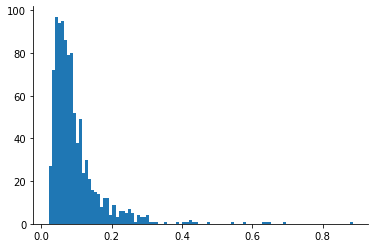

In [7]:
parms_true = np.array([3, 5])
f = bsm.loss_model("Inverse-Gamma", ["r", "m"])
X= 1 / np.random.gamma(parms_true[0], parms_true[1], size = 1000)  
plt.hist(X,bins=100)
sns.despine()

In [8]:
r_prior, m_prior = bsm.prior_model('gamma','r', 1, 1), bsm.prior_model('gamma','m', 1, 1)
prior_single_model = bsm.independent_priors([r_prior, m_prior])
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 2000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_single_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma prior distribution
Generation: 1 ;temperature: 0.00020313262939453125 ;ESS: 999 ;steps:5 ;particle moved: 99.2%
Generation: 2 ;temperature: 0.0010584916067273298 ;ESS: 999 ;steps:5 ;particle moved: 99.05000000000001%
Generation: 3 ;temperature: 0.004195372721745345 ;ESS: 1000 ;steps:6 ;particle moved: 98.9%
Generation: 4 ;temperature: 0.013094474489132236 ;ESS: 1000 ;steps:6 ;particle moved: 98.9%
Generation: 5 ;temperature: 0.03984517139274215 ;ESS: 999 ;steps:7 ;particle moved: 99.45%
Generation: 6 ;temperature: 0.12397804139330726 ;ESS: 999 ;steps:7 ;particle moved: 99.15%
Generation: 7 ;temperature: 0.3944339257809695 ;ESS: 1000 ;steps:7 ;particle moved: 98.7%
Generation: 8 ;temperature: 1.0 ;ESS: 1216 ;steps:7 ;particle moved: 98.9%
Wall time: 8.54 s


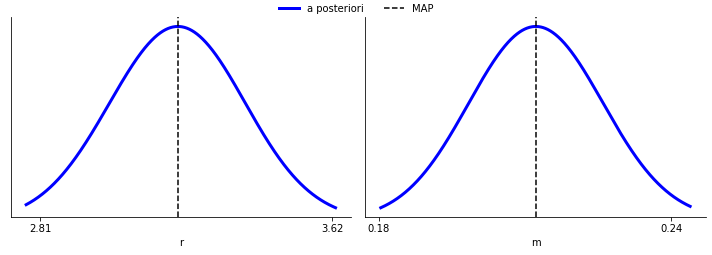

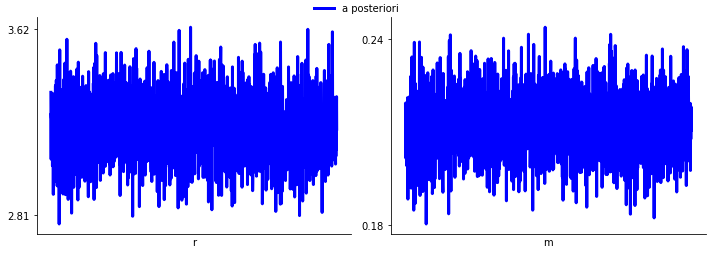

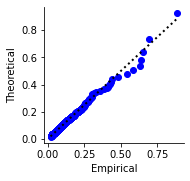

In [9]:
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
f.set_ppf()
bsm.qq_plot(X, f, trace.mean().values)

## In the composite model

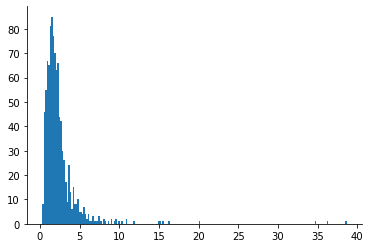

In [10]:
import bayessplicedmodels as bsm
parms_true = np.array([1/2, 2, 3, 4, 2, 0.9])
f1, f2 =  bsm.loss_model("Inverse-Gamma", ["r1", "m1"]), bsm.loss_model("Inverse-Gamma", ["r2", "m2"])
f = bsm.spliced_loss_model(f1 , f2, "continuous") 
X= f.sample(parms_true, 1000) 
r1_prior, m1_prior = bsm.prior_model('gamma','r1', 1, 1), bsm.prior_model('gamma','m1', 1, 1)
r2_prior, m2_prior = bsm.prior_model('gamma','r2', 1, 1), bsm.prior_model('gamma','m2', 1, 1)
γ_prior, p_prior =  bsm.prior_model('uniform','γ', min(X), max(X)), bsm.prior_model('beta', 'p', 0.5, 0.5)
prior_spliced_model = bsm.independent_priors([r1_prior, m1_prior, r2_prior, m2_prior, γ_prior])
plt.hist(X,bins=200)
sns.despine()

In [11]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 2000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_spliced_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma-gamma-gamma-uniform prior distribution
Generation: 1 ;temperature: 0.0019884109497070312 ;ESS: 999 ;steps:3 ;particle moved: 100.0%
Generation: 2 ;temperature: 0.0061127625317567436 ;ESS: 999 ;steps:3 ;particle moved: 99.85000000000001%
Generation: 3 ;temperature: 0.013630418088750894 ;ESS: 1000 ;steps:3 ;particle moved: 99.9%
Generation: 4 ;temperature: 0.030151988588780425 ;ESS: 1000 ;steps:3 ;particle moved: 99.6%
Generation: 5 ;temperature: 0.06583493198320334 ;ESS: 1000 ;steps:4 ;particle moved: 99.8%
Generation: 6 ;temperature: 0.12845509762839089 ;ESS: 999 ;steps:4 ;particle moved: 99.15%
Generation: 7 ;temperature: 0.24759613227982147 ;ESS: 999 ;steps:4 ;particle moved: 99.7%
Generation: 8 ;temperature: 0.5556032858125771 ;ESS: 1000 ;steps:3 ;particle moved: 98.7%
Generation: 9 ;temperature: 1.0 ;ESS: 1284 ;steps:3 ;particle moved: 99.5%
Wall time: 14 s


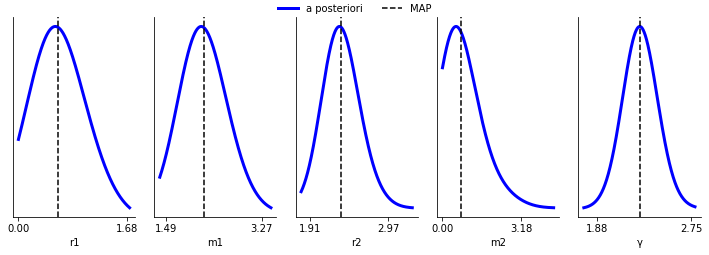

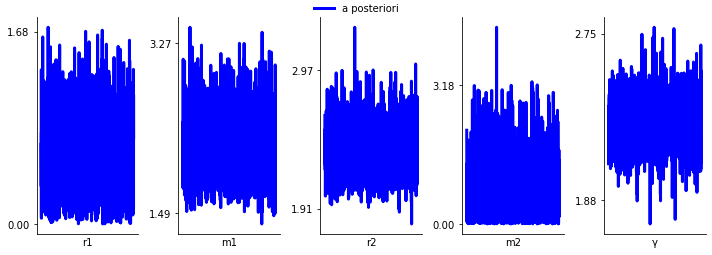

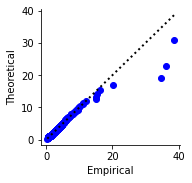

In [12]:
f.set_ppf()
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
bsm.qq_plot(X, f, trace.mean().values)

# on the danish data

In [58]:
# The data
danish = pd.read_csv("Data/danish.csv").x
X = danish.values
# Model for the bulk distribution
body_model_names = ["Inverse-Gamma","Weibull"]
body_model_param_names = [["r1", "m1"], ["r1", "m1"]]
# Prior distributions over the parameters of the bulk distribution
body_model_priors= [
                [ bsm.prior_model('gamma',body_model_param_names[0][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[0][1], 1, 1)],
[ bsm.prior_model('gamma',body_model_param_names[1][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[1][1], 1, 1)]
]

# Model for the tail of the distribution
tail_model_names = ["Lomax", "Log-Logistic" , "Burr", "Pareto-Tail", "GPD-Tail", "Inverse-Gamma", "Weibull"]
# tail_model_names = ["Log-Logistic", "Lomax"]
tail_model_param_names = [["β2", "σ2"], ["α2", "σ2"], ["α2", "β2", "σ2"], ["α2"], ["ξ2","σ2"], ["r2", "m2"], ["k2", "β2"]]

# Prior distributions over the parameters of the tail distribution
tail_model_priors= [[bsm.prior_model('gamma',tail_model_param_names[0][0], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[0][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[1][0], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[1][1], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[2][0], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[2][1], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[2][2], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[3][0], 1, 1)],
                [bsm.prior_model('gamma',tail_model_param_names[4][0], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[4][1], 1, 1)], 
                    [bsm.prior_model('gamma',tail_model_param_names[5][0], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[5][1], 1, 1)],
                    [bsm.prior_model('gamma',tail_model_param_names[6][0], 1, 1), 
                 bsm.prior_model('gamma',tail_model_param_names[6][1], 1, 1)]
]
γ_prior, p_prior = bsm.prior_model('uniform', "γ", min(X), max(X)), bsm.prior_model('uniform',"p", 0, 1)

#Splicing model type
splicing_types = ["continuous", "simple"]

# Setting the models
fs, f_names, prior_spliced_model = [], [], []
for i in range(len(body_model_names)):
    for j in range(len(tail_model_names)):
        for splicing_type in splicing_types:
            f1, f2 =  bsm.loss_model(body_model_names[i], body_model_param_names[i]), bsm.loss_model(tail_model_names[j], tail_model_param_names[j])
            fs.append(bsm.spliced_loss_model(f1 , f2, splicing_type))
            f_names.append(body_model_names[i] +"-"+ tail_model_names[j]+"-"+splicing_type)
            if splicing_type == "disjoint": 
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior, p_prior]))
            else:
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior]))
for f in fs:
    f.set_ppf()
fs_dict = dict(zip(f_names, fs))

In [60]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 5, 1/2, 0.99, 25, 1e-6, False, 4, False
def fit_spliced_models(i):
    # print(f_names[i])
    trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, fs[i], popSize, prior_spliced_model[i], ρ, c,n_step_max, err, paralell, 4, verbose)
    return([trace, log_marg, DIC, WAIC])
%time res = Parallel(n_jobs=4)(delayed(fit_spliced_models)(i) for i in range(len(f_names)))
# %time res = [fit_spliced_models(i) for i in range(len(f_names))]


Wall time: 52.7 s


In [19]:
fit_spliced_models_dic = dict(zip(f_names, res))
γ_map = np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))])
spliced_model_df = pd.DataFrame({'model':f_names,
                                 "d": np.array([f.d for f in fs]),
                                 "γ_map": np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))]),
                                 'log_marg':  np.array([fit_spliced_models_dic[f_names[k]][1] for k in range(len(fit_spliced_models_dic))]), 
                                 "DIC": np.array([fit_spliced_models_dic[f_names[k]][2] for k in range(len(fit_spliced_models_dic))]), 
                                 "WAIC":np.array([fit_spliced_models_dic[f_names[k]][3] for k in range(len(fit_spliced_models_dic))])})
spliced_model_df["posterior_probability"] = np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"])) / np.sum(np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"]))) 

spliced_model_df["Wass_dist"] = np.array([bsm.compute_Wasserstein(X, fs_dict[model_name], fit_spliced_models_dic[model_name][0].mean().values, 1) for model_name in spliced_model_df["model"].values])
spliced_model_df.sort_values(by='Wass_dist', ascending=True)

,model,d,γ_map,log_marg,DIC,WAIC,posterior_probability,Wass_dist
2,Inverse-Gamma-Log-Logistic-disjoint,6,1.761512,-3963.348020,7816.114368,7834.756667,5.715437e-62,410.949919
20,Inverse-Gamma-Inverse-Weibull-disjoint,6,1.770924,-3945.991051,7822.189044,7822.219540,1.972811e-54,421.024145
11,Inverse-Gamma-Pareto-Tail-disjoint,5,3.030188,-3967.918889,7826.078635,7849.450862,5.914884e-64,434.222037
18,Inverse-Gamma-Inverse-Weibull-continuous,5,0.937791,-3892.324135,7658.096572,7679.612016,4.002492e-31,443.672673
17,Inverse-Gamma-Inverse-Gamma-disjoint,6,3.567527,-3987.948361,7854.136641,7875.910490,1.183741e-72,469.204742
13,Inverse-Gamma-GPD-Tail-simple,5,1.665596,-3975.056285,7849.526491,7867.136908,4.701261e-67,473.493138
6,Inverse-Gamma-Burr-continuous,6,0.963359,-3924.922158,7677.276153,7696.384756,2.787335e-45,482.349876
7,Inverse-Gamma-Burr-simple,6,0.926021,-3927.690507,7733.031982,7753.224028,1.749486e-46,503.852740
15,Inverse-Gamma-Inverse-Gamma-continuous,5,0.939424,-3864.354481,7663.287953,7681.825071,5.615610e-19,527.992398
3,Inverse-Gamma-Lomax-continuous,5,0.948213,-3884.723848,7669.530481,7691.177003,8.000064e-28,534.980380


C:\Users\pierr\Documents\code\BayesSplicedModels\bayessplicedmodels\posterior_analysis.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 1, figsize=(2.5, 2.5))


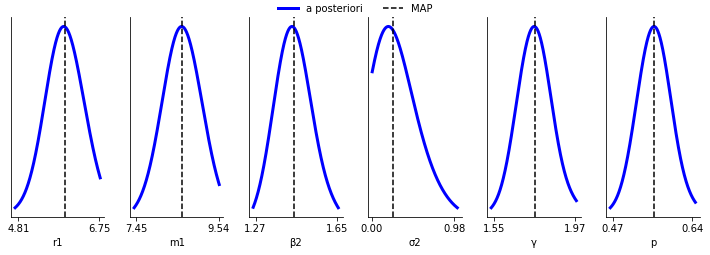

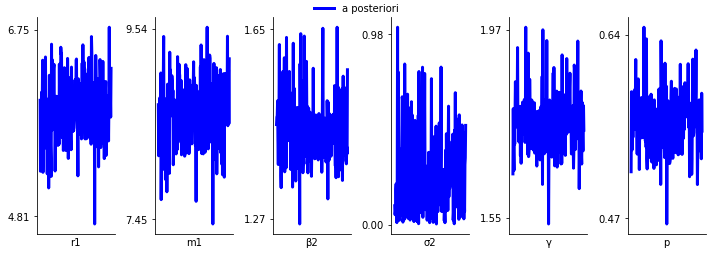

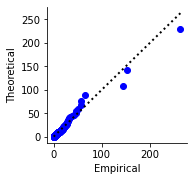

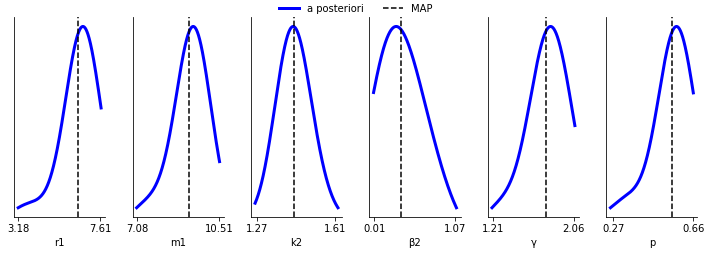

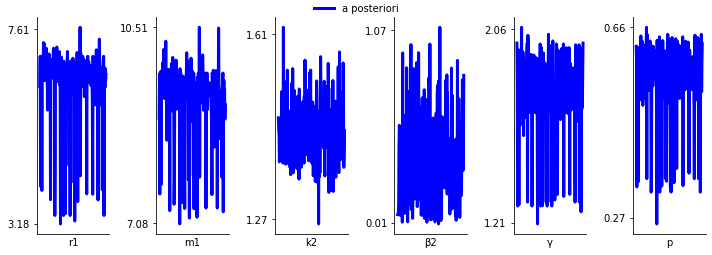

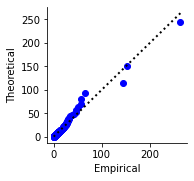

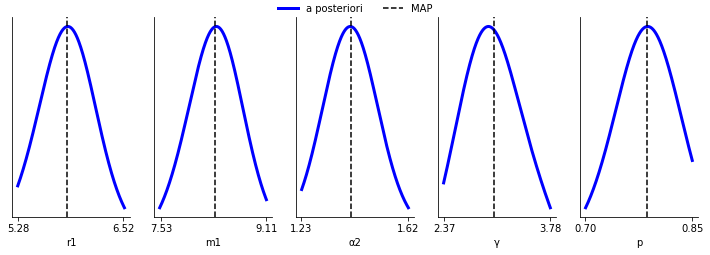

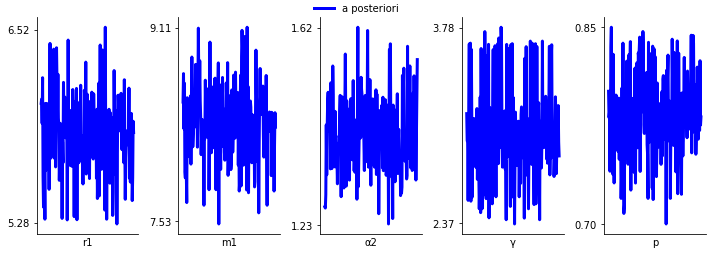

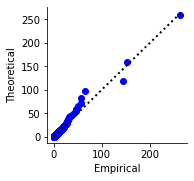

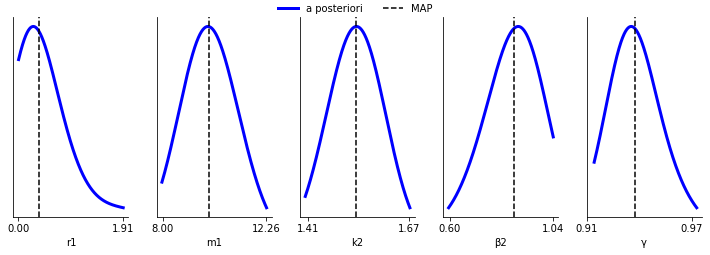

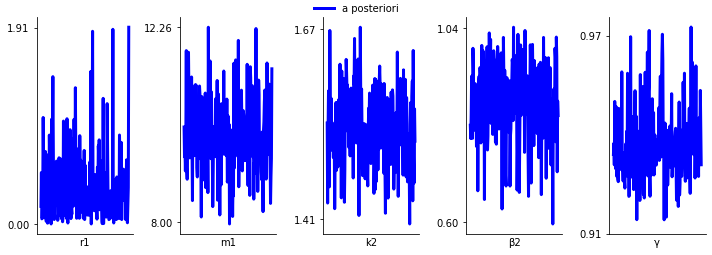

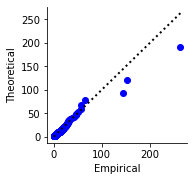

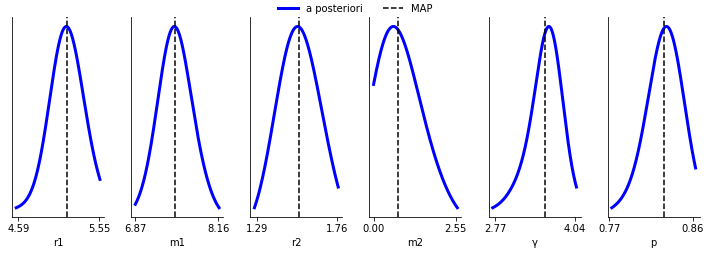

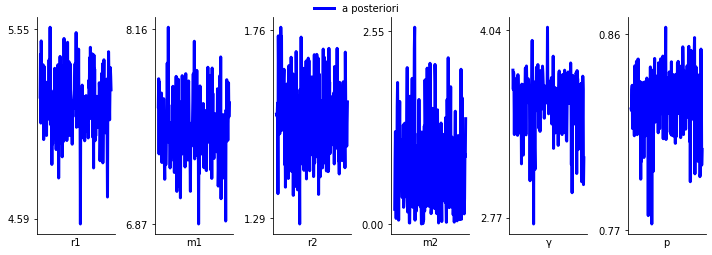

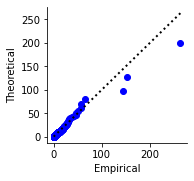

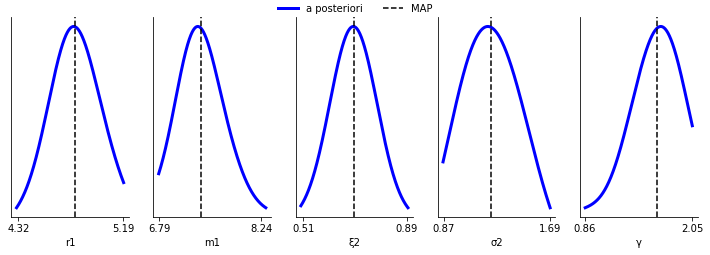

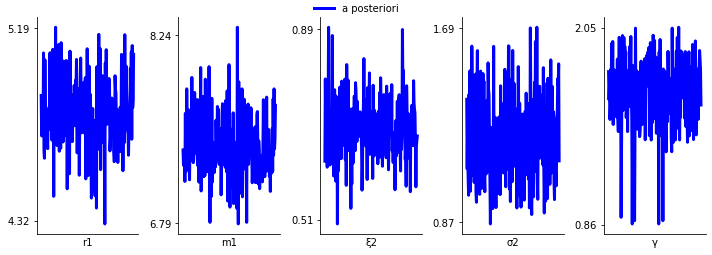

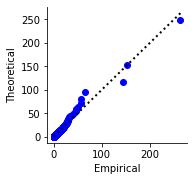

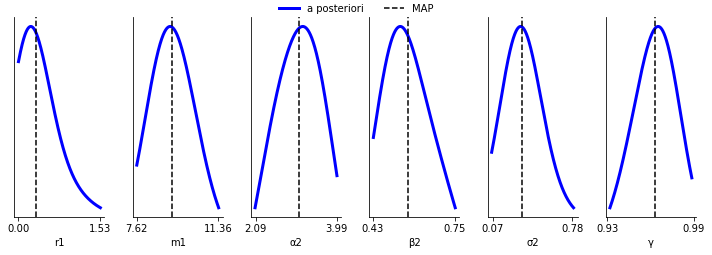

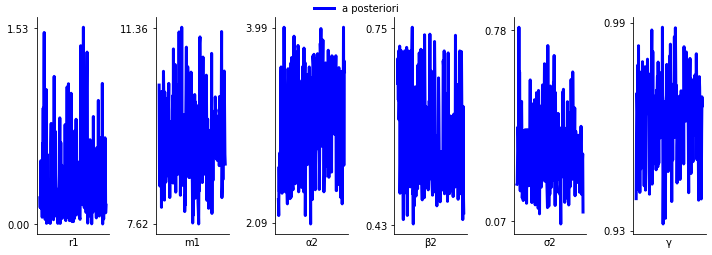

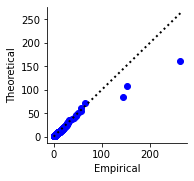

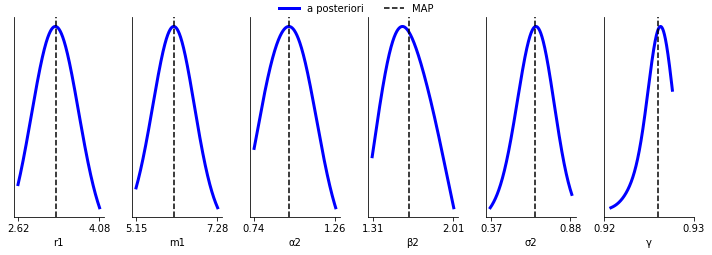

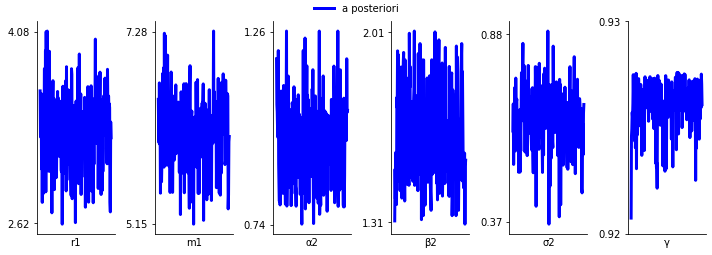

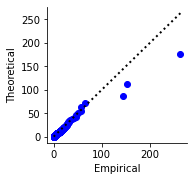

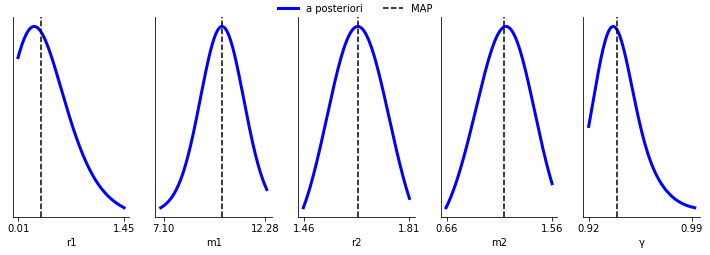

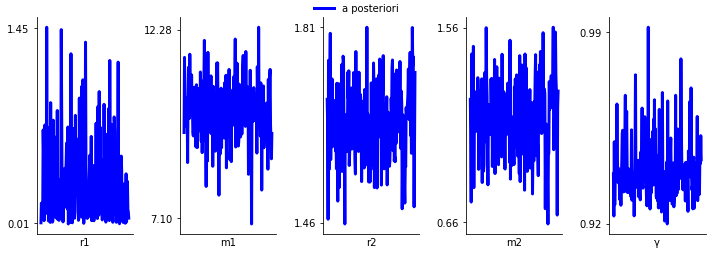

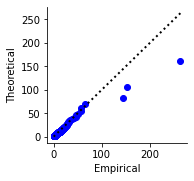

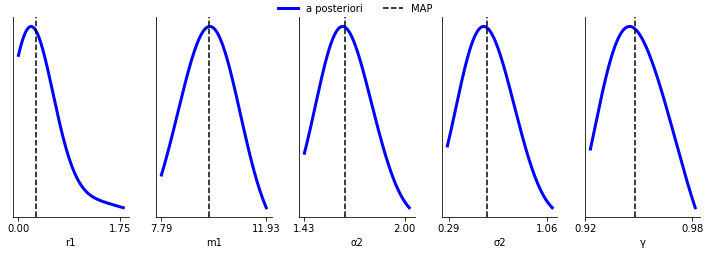

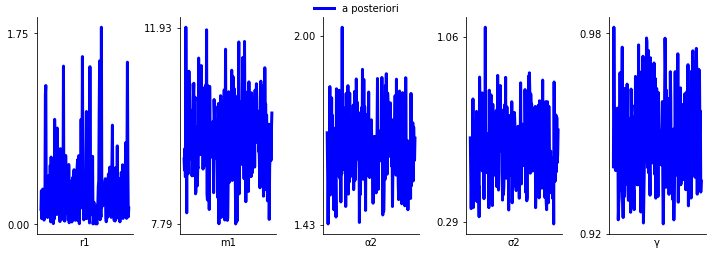

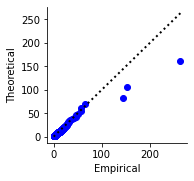

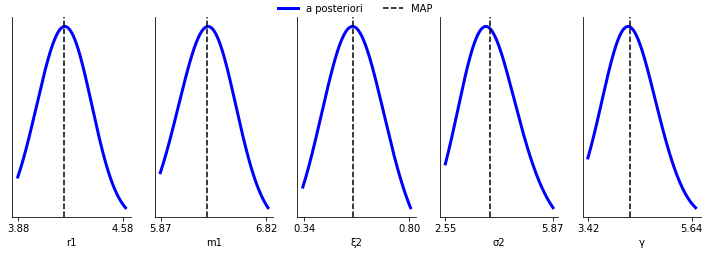

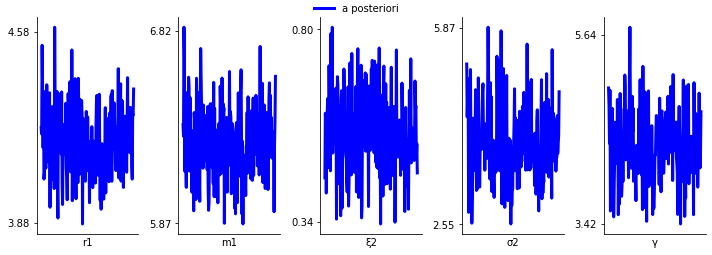

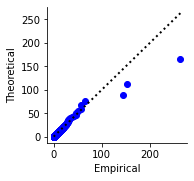

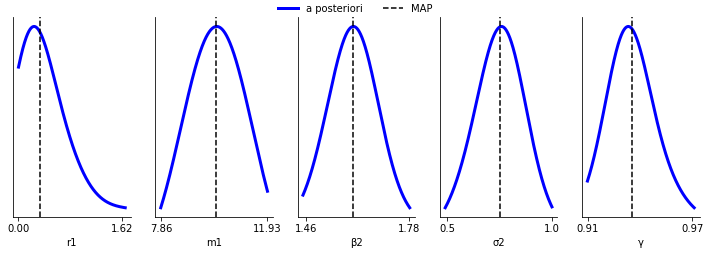

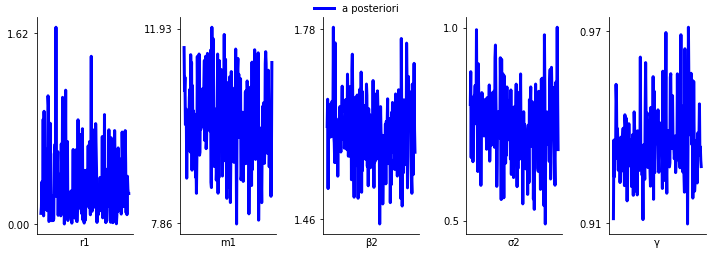

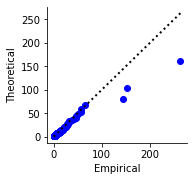

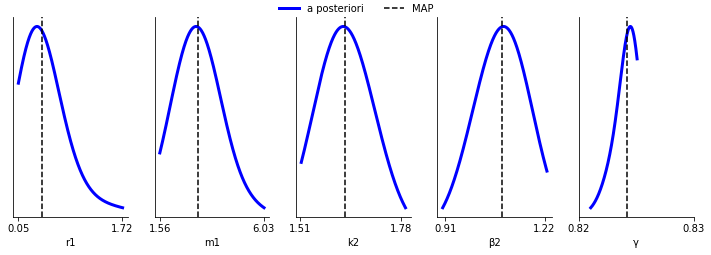

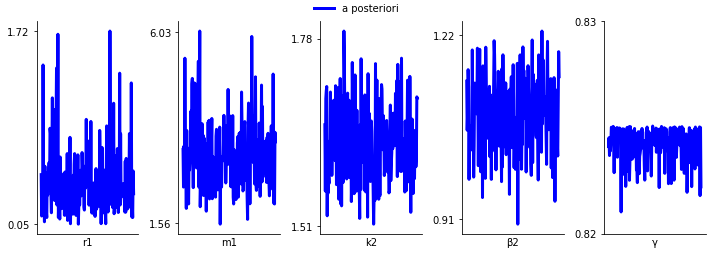

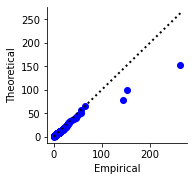

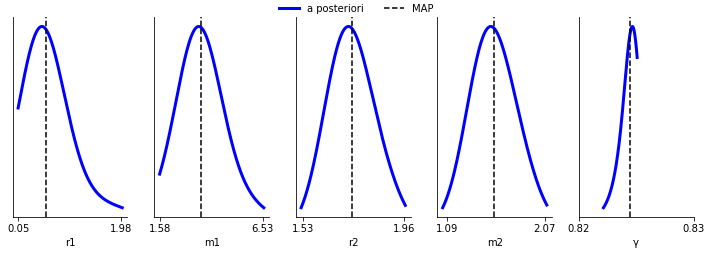

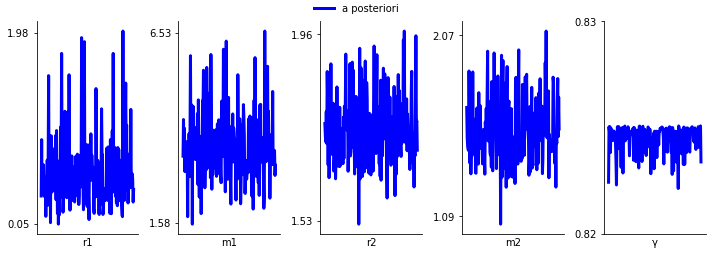

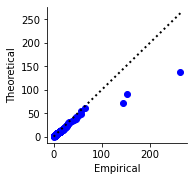

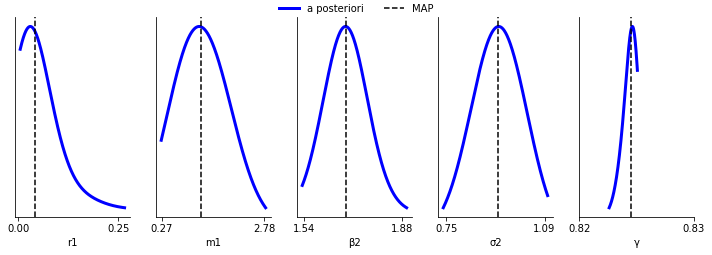

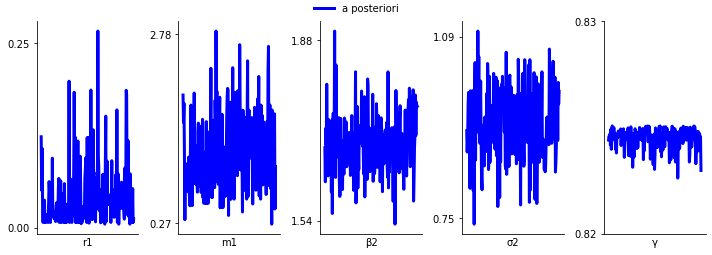

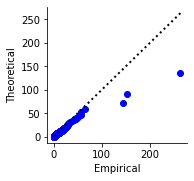

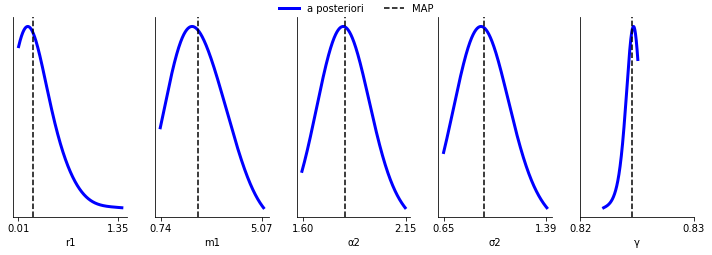

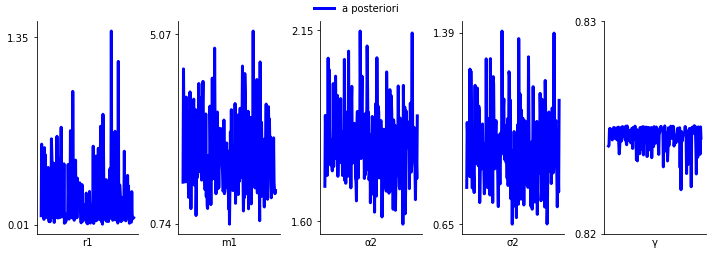

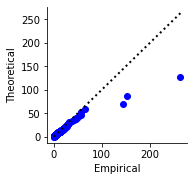

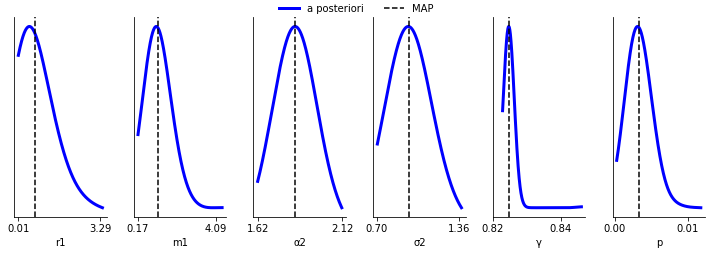

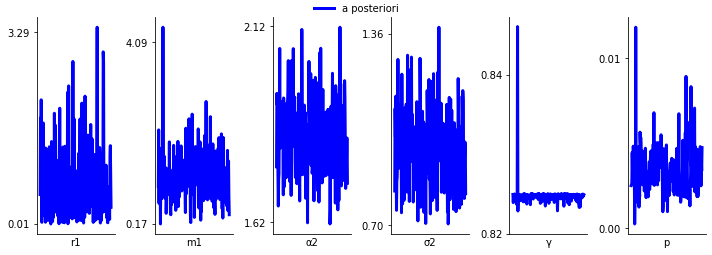

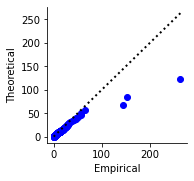

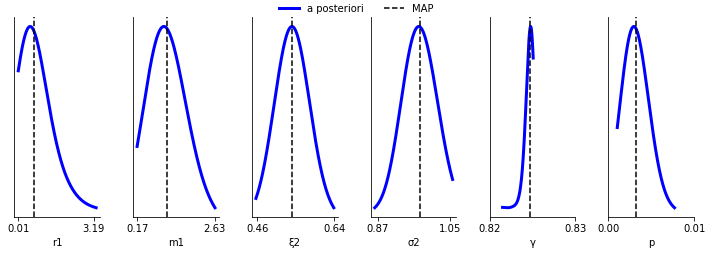

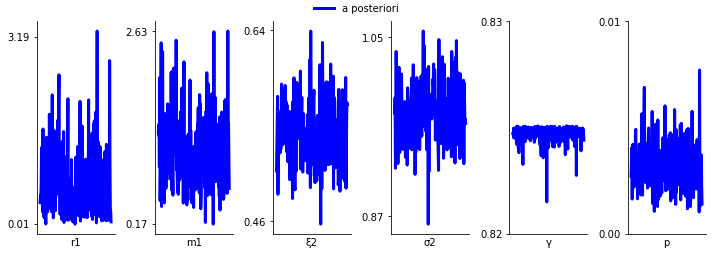

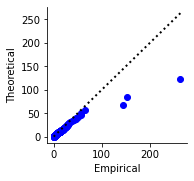

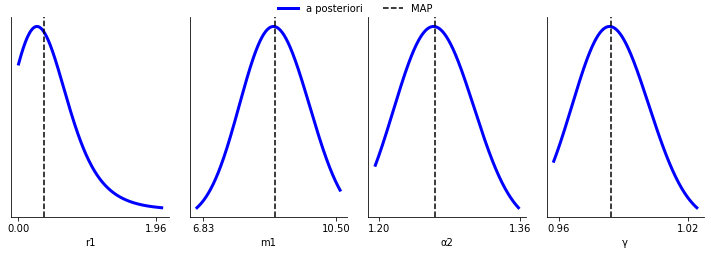

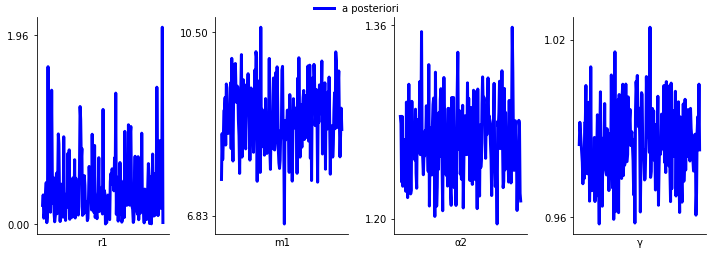

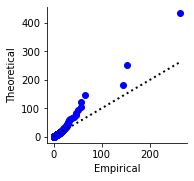

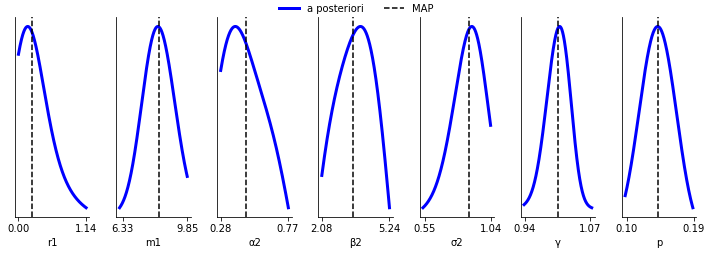

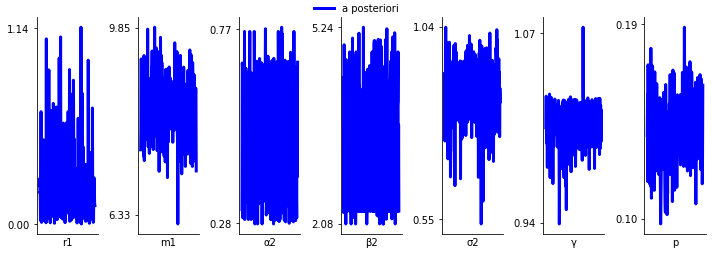

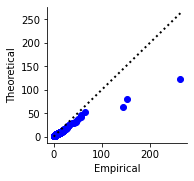

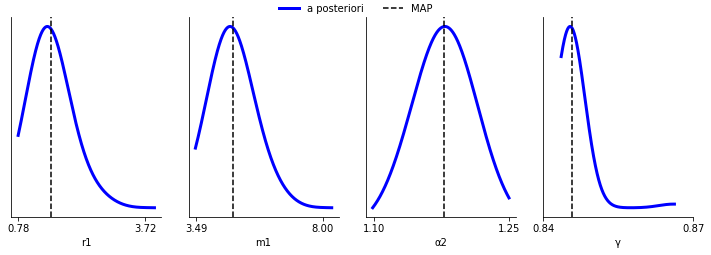

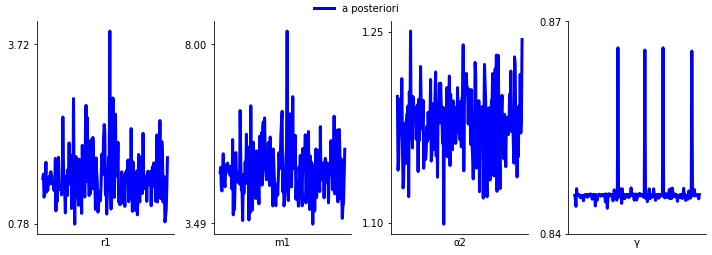

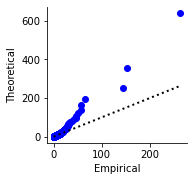

In [20]:
model_names = spliced_model_df.sort_values(by='Wass_dist', ascending=True)["model"]
for model_name in model_names:
    f, trace = fs_dict[model_name], fit_spliced_models_dic[model_name][0]
    # print(trace.mean().values)
    bsm.posterior_plots(f, trace)
    bsm.trace_plots(f, trace)
    bsm.qq_plot(X, f, trace.mean().values)